# Average Bubble

In [1]:
import os,sys
sys.path.append('./bubbles_codes/')
from bubble_tools import *
from experiment import *
from plotting import *

In [2]:
tmp = 3
phi0, temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
exp_params = np.asarray([nLat, lamb, phi0, temp])
labs = labl(lamb, phi0, temp)
print('Looking at at lambda, T, phi0, m2, sigma:', lamb, temp, phi0, m2(lamb), sigmafld)

crit_radList    = np.array(np.linspace(10, 60, 20), dtype='int'); print(crit_radList)
crit_threshList = right_Vmax.x + np.linspace(1, 6, 20) * sigmafld; print(crit_threshList)

win = 200
considerMaxVel = 0.9 # excludes faster bubbles from average

plots = False
get_data = False
get_plotcomp = True

if get_data:
    all_data, all_vels = [], []
    for sim in range(minSim, maxSim):      
        path2RESTsim = rest_sim_location(*exp_params, sim)
        if os.path.exists(path2RESTsim):
            sim, bubble, totbeta = np.load(path2RESTsim)
            if np.abs(totbeta) < considerMaxVel:
                all_vels.append(np.array([sim, totbeta]))
                all_data.append(np.array([sim, bubble]))
    print('Total bubbles included:', len(all_data))


Looking at at lambda, T, phi0, m2, sigma: 1.5 0.12 1.3962634015954636 0.01 0.3571216688274275
[10 12 15 17 20 23 25 28 31 33 36 38 41 44 46 49 52 54 57 60]
[4.60895821 4.7029376  4.79691699 4.89089637 4.98487576 5.07885515
 5.17283453 5.26681392 5.36079331 5.45477269 5.54875208 5.64273147
 5.73671085 5.83069024 5.92466962 6.01864901 6.1126284  6.20660778
 6.30058717 6.39456656]


final_crit_rad = [44]
final_crit_thresh =  [5.45477269]


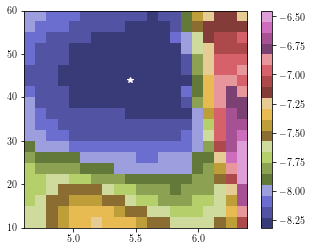

In [3]:
if get_plotcomp:
    loadedBubbles = np.zeros((len(crit_radList), len(crit_threshList), 2, 3, 2*win+1, 2*win+1))
    varmat        = np.zeros((len(crit_radList), len(crit_threshList)))

    for cind, cth in enumerate(crit_radList):
        for tind, tsh in enumerate(crit_threshList):
            try:
                loadedBubbles[cind, tind] = np.load(average_file(*exp_params)+'_critrad'+str(cth)+'_crittsh'+str(tsh)+'.npy')
            except:
                continue
            tp = 1 # 0 for average, 1 for error
            cp = 0 # 0 - field, 1 - momentum, 2 - gradient
            delt1 = 30

            bubble = loadedBubbles[cind, tind, tp, cp]
            nT, nN = np.shape(bubble)
            tl, tr, xl, xr = max(0, win-delt1), min(nT, win+delt1), max(0, win-delt1), min(nN, win+delt1)
            varmat[cind, tind] = np.mean(np.abs(bubble[tl:tr, xl:xr]))

    colmin, rowmin = np.where(varmat == np.min(varmat))
    final_crit_rad = crit_radList[colmin]
    final_crit_thresh = crit_threshList[rowmin]
    if len(final_crit_rad) != 1:
        if len(final_crit_rad) == 0: print('Failed')
        elif len(final_crit_rad) > 1:
            final_crit_rad = final_crit_rad[0]
            final_crit_thresh = final_crit_thresh[0]
    print('final_crit_rad =', final_crit_rad)
    print('final_crit_thresh = ', final_crit_thresh)

    fig, ax = plt.subplots(1,1, figsize = (5,4))
    ext  = [crit_threshList[0], crit_threshList[-1], crit_radList[0], crit_radList[-1]]
    im0  = plt.imshow(np.log(varmat), interpolation='none', extent=ext, aspect='auto', origin='lower', cmap='tab20b')
    plt.plot(final_crit_thresh, final_crit_rad, color='white', marker='*')
    clb0 = plt.colorbar(im0, ax = ax); plt.show()

    if False:
        fig, ax = plt.subplots(len(crit_radList), len(crit_threshList), figsize = (len(crit_threshList)*5, len(crit_radList)*5))
        for cind, cth in enumerate(crit_radList):
            for tind, tsh in enumerate(crit_threshList):
                tp = 0 # 0 for average, 1 for error
                delt = 50

                average_bubble = loadedBubbles[cind][tind][tp, cp]
                nT, nN = np.shape(average_bubble)
                tl, tr, xl, xr = max(0, win-delt), min(nT, win+delt), max(0, win-delt), min(nN, win+delt)
                ext = [xl, xr, tl, tr]
                bubble2plot = average_bubble[tl:tr, xl:xr]

                im0  = ax[cind,tind].imshow(bubble2plot, interpolation='none', extent=ext, origin='lower', cmap='tab20b')
                clb0 = plt.colorbar(im0, ax = ax[cind,tind])
                ax[cind,tind].plot(win, win, color='k', marker='o', ms='5', label='size='+str(cth)+', thresh='+str(format(tsh, '1.2f')))
                ax[cind,tind].legend(title=r'$T=$'+str(temp), loc=4, fontsize='small', fancybox=True, frameon=True, framealpha=0.75, borderpad=0.3)
        plt.show()

In [4]:
# Little script to produce bubbles of same field kind, but difference velocity brackets
if False:
    velsplit = 0.2
#    velsplit = 0.4

    simvels, veldata = np.array(all_vels)[:,0].astype(int), np.array(all_vels)[:,1]
    a1 = np.argwhere(np.abs(veldata) <= velsplit).flatten()
    a2 = np.argwhere(np.abs(veldata) > velsplit).flatten()
    a3 = np.sort(np.concatenate((a1,a2)))
    a4 = np.array(simvels[a1], dtype='int')
    a5 = np.array(simvels[a2], dtype='int')
    a6 = np.sort(np.concatenate((a4,a5)))
    simindlist = [a1, a2]
    simlist    = [a4, a5]
    print(len(a1), len(a2))

    cp = 0 # 0 - field, 1 - momentum, 2 - gradient

    for stype, (simi, simt) in enumerate(zip(simindlist, simlist)):
        part_data = np.array([all_data[i] for i in simi])
        stacks  = stack_bubbles(part_data, win, phieq, final_crit_thresh, final_crit_rad, plots)
        stacks  = average_stacks(stacks, normal, plots)
        avstack = average_bubble_stacks(stacks)
        np.save(average_file(*exp_params)+'_stype'+str(stype)+'_velsplit'+str(velsplit), avstack)
    print('Done')

    loadedBubbles = np.zeros((len(simlist), 2, 3, 2*win+1, 2*win+1))
    varmat = np.zeros((len(simlist)))
    for stype, (simi, simt) in enumerate(zip(simindlist, simlist)):
        loadedBubbles[stype] = np.load(average_file(*exp_params)+'_stype'+str(stype)+'_velsplit'+str(velsplit)+'.npy')
        tp = 1 # 0 for average, 1 for error
        bubble = loadedBubbles[stype, tp, cp]
        nT, nN = np.shape(bubble)
        delt1 = 30
        tl, tr, xl, xr = max(0, win-delt1), min(nT, win+delt1), max(0, win-delt1), min(nN, win+delt1)
        varmat[stype] = np.mean(np.abs(bubble[tl:tr, xl:xr]))


    fig, ax = plt.subplots(1,1, figsize = (5,4))
    plt.plot(np.arange(len(simlist)), varmat); plt.show()

    fig, ax = plt.subplots(1, 2, figsize = (len(simlist)*5, 5))
    for stype, simi in enumerate(simindlist):
        tp = 0 # 0 for average, 1 for error
        average_bubble = loadedBubbles[stype][tp, cp]
        nT, nN = np.shape(average_bubble)
        delt = 100
        tl, tr, xl, xr = max(0, win-delt), min(nT, win+delt), max(0, win-delt), min(nN, win+delt)
        ext         = [xl, xr, tl, tr]
        bubble2plot = average_bubble[tl:tr, xl:xr]
        
        im0  = ax[stype].imshow(bubble2plot, interpolation='none', extent=ext, origin='lower', cmap='tab20b')
        clb0 = plt.colorbar(im0, ax = ax[stype])
        ax[stype].plot(win, win, color='k', marker='o', ms='5', label='s='+str(stype))
        ax[stype].legend(title=r'$T=$'+str(temp), loc=4, fontsize='small', fancybox=True, frameon=True, framealpha=0.75, borderpad=0.3)
    plt.show()

In [5]:
if False:
    fig, ax = plt.subplots(2, 1, figsize = (15, 10))
    ax[1].axhline(0., color='darkgray', ls='--')
    ax[0].axhline(phieq, color='darkgray', ls='--')
    ax[0].axhline(2.*np.pi, color='darkgray', ls='--') 
    ax[0].yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
    ax[0].yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))

    for coln in [0, 1]:
        bool = True
        secondary_lines, secondary_labels = [], []
        for stype, simi in enumerate(simindlist):        
            average_bubble = loadedBubbles[stype][0, 0]
            nT, nN = np.shape(average_bubble)
            tcen, xcen  = find_nucleation_center2(average_bubble, phieq, final_crit_thresh, final_crit_rad)
            tl, tr      = max(0, tcen-win), min(nT-1, tcen+win)
            xl, xr      = max(0, xcen-win), min(nN-1, xcen+win)
            ext         = [xl, xr, tl, tr]
            bubble2plot = loadedBubbles[stype][0, coln][tl:tr, xl:xr]

            timesList = np.array(np.sort(np.linspace(tcen-30, tcen+20, 4).tolist()+[tcen]), dtype='int')
            print(tcen, xcen, timesList)

            cols = cycle(['indigo', 'forestgreen', 'orange', 'blue', 'orangered'])
            labs = r'$\phi_0=$'+str('%.2f'%phi0)+r', $\lambda=$'+str(lamb)+r', $T=$'+str(temp)
            lsl = ('-' if stype==1 else ':')
            for tt in timesList:
                col = next(cols)
                data  = bubble2plot[tt]
                xlist = np.linspace(-xcen, nN-xcen, len(data))

                spline  = scp.interpolate.splrep(xlist, data)
                r       = np.linspace(xlist[0], xlist[-1], 2000)
                profile = scp.interpolate.splev(r, spline)

                if tt == tcen:
                    secondary_labels.append(labs)
                    l1, = ax[coln].plot(r, profile, color=col, ls=lsl)
                    secondary_lines.append(l1)

                if bool:
                    ax[coln].plot(r, profile, color=col, ls=lsl, label=(r'$\Delta \bar{t} = $'+str(tt-tcen) if tt!=tcen else r'$\bar{t}_{\rm crit} = $'+str(tt)))
                else:
                    ax[coln].plot(r, profile, color=col, ls=lsl)

            bool = False
        ax[coln].add_artist(ax[coln].legend(secondary_lines, secondary_labels, loc=2))

    ax[0].set_ylabel(r'$\bar{\phi}(r)$')
    ax[1].set_ylabel(r'$\bar{\Pi}(r)$')
    for axx in ax.flatten():
        axx.set_xlabel(r'$m \; r$')
        axx.legend(loc=1)
        axx.grid(False)
    plt.show()


In [6]:
bubbleList, velocitesList, instantonList, tmpList, fldcritList, tcritList, encritList = [], [], [], [], [], [], []
for tmp in [0,1,2,3]:
    phi0, temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
    exp_params = np.asarray([nLat, lamb, phi0, temp])

    bubbleList.append(np.load(average_file(*exp_params)))
    velocitesList.append(np.load(velocities_file(*exp_params)))
    instantonList.append(np.load(instanton_file(*exp_params)))
    tmpList.append(tmp)
    fldcritList.append(np.load(critfield_file(*exp_params)))
    tcritList.append(np.load(crittimes_file(*exp_params)))
    encritList.append(np.load(critenerg_file(*exp_params)))


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/tmp/ipykernel_78941/1283657770.py:44: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  if cp==0: cbar = grid[ii].cax.colorbar(im[maxable], ticks=mticker.MultipleLocator(np.pi/2), format=mticker.FuncFormatter(multiple_formatter()))
/home/dpirvu/.conda/envs/conda_env/lib/python3.8/site-packages/mpl_toolkits/axes_grid1/axes_grid.py:51: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar


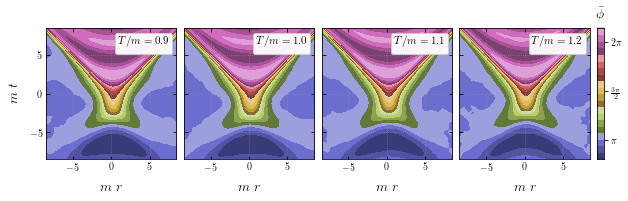

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/tmp/ipykernel_78941/1283657770.py:45: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  else: cbar = grid[ii].cax.colorbar(im[maxable])


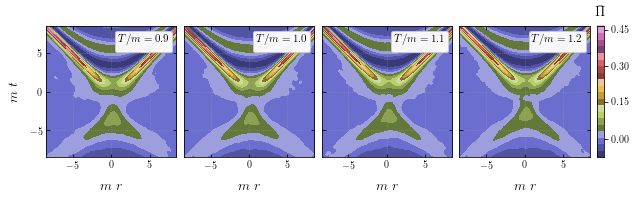

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


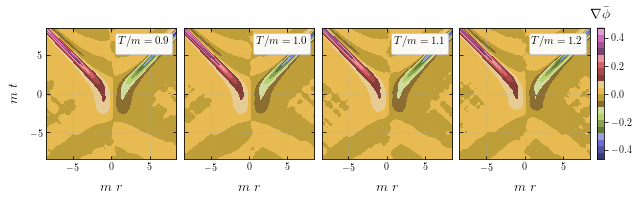

In [7]:
tp = 0# 0 for average, 1 for error

titl = [r'$\bar{\phi}$',  r'$\bar{\Pi}$', r'$\nabla \bar{\phi}$']
for cp in range(3): # 0 - field, 1 - momentum, 2 - gradient

    if cp==0: valmin, valmax = phieq, phieq
    else: valmin, valmax = 0.1, 0.1

    crit_rad = 50
    crit_thresh = right_Vmax.x + 2.*sigmafld
    win = 110
    for ii, average_bubble in enumerate(bubbleList):
        bubble2measure = average_bubble[0,0]
        nT, nN = np.shape(bubble2measure)
        tcen, xcen = find_nucleation_center(bubble2measure, phieq, crit_thresh, crit_rad)
        tcen -= 20
        tl,tr = max(0, tcen-win), min(nT-1, tcen+win)
        xl,xr = max(0, xcen-win), min(nN-1, xcen+win)

        bubble2plot = average_bubble[tp,cp][tl:tr,xl:xr]
        if np.amin(bubble2plot) < valmin: valmin = np.amin(bubble2plot)
        if np.amax(bubble2plot) > valmax: valmax, maxable = np.amax(bubble2plot), ii

    fig = plt.figure(figsize = (10, 3.5))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, len(bubbleList)), share_all=True, axes_pad=0.1, cbar_location="right", cbar_mode="single")
    im = [[]]*len(bubbleList)
    for ii, average_bubble in enumerate(bubbleList):
        tmp = tmpList[ii]
        phi0, temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
        exp_params = np.asarray([nLat, lamb, phi0, temp])
        ext = np.array([xl-xcen,xr-xcen,tl-tcen,tr-tcen])*np.sqrt(m2(lamb))*dx

        bubble2plot = average_bubble[tp,cp][tl:tr,xl:xr]
        im[ii] = grid[ii].imshow(bubble2plot, interpolation='Gaussian', extent=ext, origin='lower', cmap='tab20b')
        im[ii].set_clim(vmin=valmin, vmax=valmax)

        labss = r'$T/m = {}$'.format(round(temp/np.sqrt(m2(lamb)),1))#labl(lamb, phi0, temp)
        grid[ii].legend(title=labss, loc=1, fontsize='small', fancybox=True, frameon=True, framealpha=0.95, borderpad=0.3)
        grid[ii].tick_params(direction='in', which='both', top=True, right=True)
        grid[ii].set(xlabel=r'$m \; r$')
        grid[ii].grid(ls=':', color='darkgray', alpha=0.5)
        grid[0].set(ylabel=r'$m \; t$')

    if cp==0: cbar = grid[ii].cax.colorbar(im[maxable], ticks=mticker.MultipleLocator(np.pi/2), format=mticker.FuncFormatter(multiple_formatter()))
    else: cbar = grid[ii].cax.colorbar(im[maxable])
    grid[ii].cax.toggle_label(True)
    grid[ii].cax.set_title(titl[cp])

    plt.savefig('./plots/average_vacuum_bubble_comparison_'+str(cp)+'.pdf')
    plt.show()


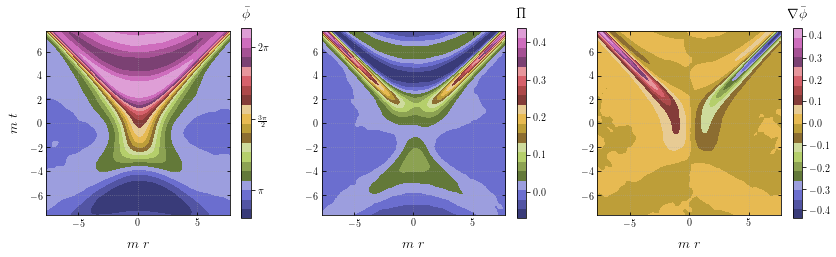

In [8]:
tp = 0# 0 for average, 1 for error

titl = [r'$\bar{\phi}$',  r'$\bar{\Pi}$', r'$\nabla\bar{\phi}$']

fig, ax = plt.subplots(1, 3, figsize = (14, 3.5))
for cp in range(3): # 0 - field, 1 - momentum, 2 - gradient
    tmp = tmpList[0]
    average_bubble = bubbleList[tmp]
    phi0, temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
    exp_params = np.asarray([nLat, lamb, phi0, temp])

    crit_rad = 50
    crit_thresh = right_Vmax.x + 2.*sigmafld
    win = 100

    bubble2measure = average_bubble[0,0]
    nT, nN = np.shape(bubble2measure)
    tcen, xcen = find_nucleation_center(bubble2measure, phieq, crit_thresh, crit_rad)
    tcen-=20
    tl,tr = max(0, tcen-win), min(nT-1, tcen+win)
    xl,xr = max(0, xcen-win), min(nN-1, xcen+win)
    ext = np.array([xl-xcen,xr-xcen,tl-tcen,tr-tcen])*np.sqrt(m2(lamb))*dx

    bubble2plot = average_bubble[tp,cp][tl:tr,xl:xr]

    im = ax[cp].imshow(bubble2plot, interpolation='Gaussian', extent=ext, origin='lower', cmap='tab20b')
    if cp==0: cbar = fig.colorbar(im,ax=ax[cp], ticks=mticker.MultipleLocator(np.pi/2), format=mticker.FuncFormatter(multiple_formatter()))
    else: cbar = fig.colorbar(im, ax=ax[cp])
    cbar.ax.set_title(titl[cp])

    ax[cp].tick_params(direction='in', which='both', top=True, right=True)
    #ax[cp].set(xlabel=r'$\phi_0^{-1} \sqrt{V_0} \; r$')
    ax[cp].set(xlabel=r'$m \; r$')

    ax[cp].grid(ls=':', color='darkgray', alpha=0.5)
    #ax[0].set(ylabel=r'$\phi_0^{-1} \sqrt{V_0} \; t$')
    ax[0].set(ylabel=r'$m \; t$')
plt.savefig('./plots/average_bubble.pdf')
plt.show()


/tmp/ipykernel_78941/252638402.py:36: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'
  ax[cp].contour(xxx1, ttt1, bubble2plot.T, levels=lavs, aspect='auto', interpolation=None, extent=ext, origin='lower', colors='k',linewidths=0.5)


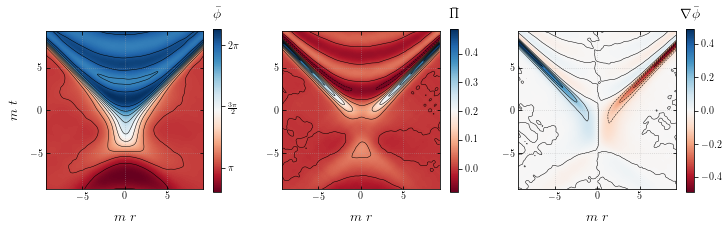

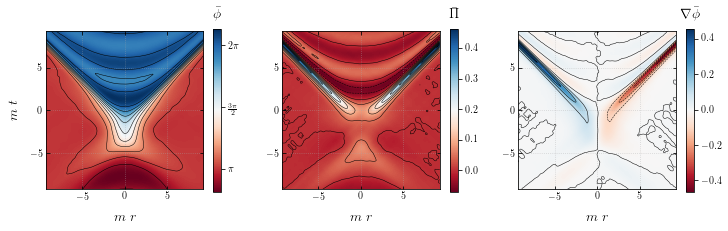

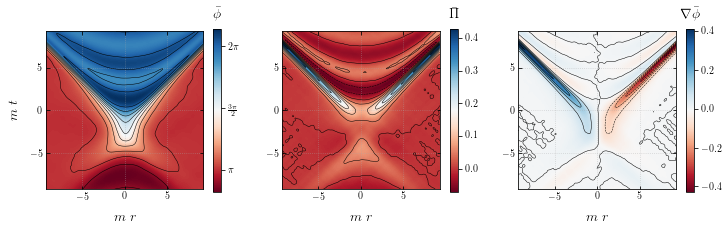

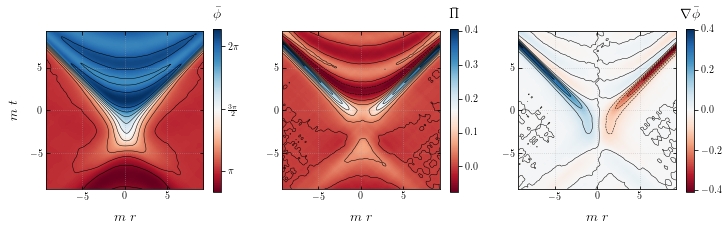

In [9]:
tp = 0# 0 for average, 1 for error

titl = [r'$\bar{\phi}$',  r'$\bar{\Pi}$', r'$\nabla\bar{\phi}$']

for ii, average_bubble in enumerate(bubbleList):
    fig, ax = plt.subplots(1, 3, figsize = (12, 3))
    for cp in range(3): # 0 - field, 1 - momentum, 2 - gradient
        tmp = tmpList[ii]
        phi0, temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
        exp_params = np.asarray([nLat, lamb, phi0, temp])

        crit_rad = 50
        crit_thresh = right_Vmax.x + 2.*sigmafld
        win = 120

        bubble2measure = average_bubble[0,0]
        nT, nN = np.shape(bubble2measure)
        tcen, xcen = find_nucleation_center(bubble2measure, phieq, crit_thresh, crit_rad)
        tl,tr = max(0, tcen-win), min(nT-1, tcen+win)
        xl,xr = max(0, xcen-win), min(nN-1, xcen+win)
        ext = np.array([xl-xcen,xr-xcen,tl-tcen,tr-tcen])*np.sqrt(m2(lamb))*dx

        bubble2plot = average_bubble[tp,cp][tl:tr,xl:xr]

        im = ax[cp].imshow(bubble2plot, interpolation=None, extent=ext, origin='lower', cmap='RdBu')
        if cp==0: cbar = fig.colorbar(im,ax=ax[cp], ticks=mticker.MultipleLocator(np.pi/2), format=mticker.FuncFormatter(multiple_formatter()))
        else: cbar = fig.colorbar(im, ax=ax[cp])
        cbar.ax.set_title(titl[cp])

        nT, nN = np.shape(bubble2plot)
        tt = np.linspace(tl-tcen, tr-tcen, nT)*np.sqrt(m2(lamb))*dx
        xx = np.linspace(xl-xcen, xr-xcen, nN)*np.sqrt(m2(lamb))*dx
        ttt1, xxx1 = np.meshgrid(tt, xx)

        lavs = [10, 10, 10][cp]
        ax[cp].contour(xxx1, ttt1, bubble2plot.T, levels=lavs, aspect='auto', interpolation=None, extent=ext, origin='lower', colors='k',linewidths=0.5)

        ax[cp].tick_params(direction='in', which='both', top=True, right=True)
        #ax[cp].set(xlabel=r'$\phi_0^{-1} \sqrt{V_0} \; r$')
        ax[cp].set(xlabel=r'$m \; r$')
        labss = r'$T/m = {}$'.format(round(temp/np.sqrt(m2(lamb)),1))#labl(lamb, phi0, temp)
        #ax[cp].legend(title=labss, loc=3, fancybox=True, frameon=True, framealpha=0.9, borderpad=0.3)
        ax[cp].grid(ls=':', color='darkgray', alpha=0.5)
        #ax[0].set(ylabel=r'$\phi_0^{-1} \sqrt{V_0} \; t$')
        ax[0].set(ylabel=r'$m \; t$')
    plt.savefig('./plots/average_bubble'+str(temp)+'.pdf', bbox_inches='tight')
    plt.show()


/tmp/ipykernel_78941/257821139.py:37: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'
  ax.contour(xxx1, ttt1, bubble2plot.T, levels=lavs, aspect='auto', interpolation=None, extent=ext, origin='lower', colors='k',linewidths=0.5)


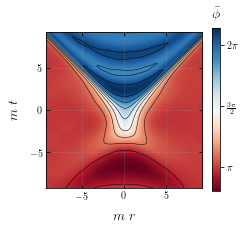

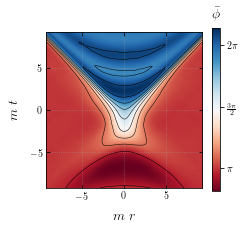

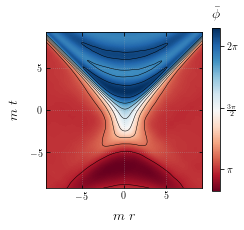

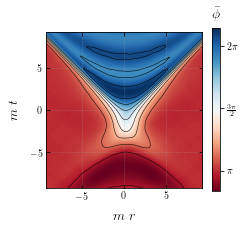

In [10]:
tp = 0# 0 for average, 1 for error

titl = [r'$\bar{\phi}$',  r'$\bar{\Pi}$', r'$\nabla\bar{\phi}$']

for ii, average_bubble in enumerate(bubbleList):
    fig, ax = plt.subplots(1, 1, figsize = (3.5, 3))

    cp = 0
    tmp = tmpList[ii]
    phi0, temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
    exp_params = np.asarray([nLat, lamb, phi0, temp])

    crit_rad = 30
    crit_thresh = right_Vmax.x + 2.*sigmafld
    win = 120

    bubble2measure = average_bubble[0,0]
    nT, nN = np.shape(bubble2measure)
    tcen, xcen = find_nucleation_center(bubble2measure, phieq, crit_thresh, crit_rad)
    tl,tr = max(0, tcen-win), min(nT-1, tcen+win)
    xl,xr = max(0, xcen-win), min(nN-1, xcen+win)
    ext = np.array([xl-xcen,xr-xcen,tl-tcen,tr-tcen])*np.sqrt(m2(lamb))*dx

    bubble2plot = average_bubble[tp,cp][tl:tr,xl:xr]

    im = ax.imshow(bubble2plot, interpolation=None, extent=ext, origin='lower', cmap='RdBu')
    cbar = fig.colorbar(im,ax=ax, ticks=mticker.MultipleLocator(np.pi/2), format=mticker.FuncFormatter(multiple_formatter()))
    cbar.ax.set_title(titl[0])

    nT, nN = np.shape(bubble2plot)
    tt = np.linspace(tl-tcen, tr-tcen, nT)*np.sqrt(m2(lamb))*dx

    xx = np.linspace(xl-xcen, xr-xcen, nN)*np.sqrt(m2(lamb))*dx
    ttt1, xxx1 = np.meshgrid(tt, xx)

    lavs = 8
    ax.contour(xxx1, ttt1, bubble2plot.T, levels=lavs, aspect='auto', interpolation=None, extent=ext, origin='lower', colors='k',linewidths=0.5)

    ax.tick_params(direction='in', which='both', top=True, right=True)
    ax.set(xlabel=r'$m \; r$')
    labss = r'$T/m = {}$'.format(round(temp/np.sqrt(m2(lamb)),1))#labl(lamb, phi0, temp)
    ax.grid(ls=':', color='darkgray', alpha=0.5)
    ax.set(ylabel=r'$m \; t$')
    plt.savefig('./plots/average_bubble'+str(temp)+'.pdf', bbox_inches='tight')
    plt.show()


/tmp/ipykernel_78941/2555127721.py:38: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'
  plt.contour(xxx1, ttt1, bubble2plot.T, levels=lavs, aspect='auto', interpolation='none', extent=ext, origin='lower', colors='k',linewidths=0.5)
No handles with labels found to put in legend.


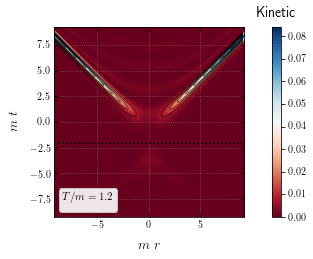

/tmp/ipykernel_78941/2555127721.py:38: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'
  plt.contour(xxx1, ttt1, bubble2plot.T, levels=lavs, aspect='auto', interpolation='none', extent=ext, origin='lower', colors='k',linewidths=0.5)
No handles with labels found to put in legend.


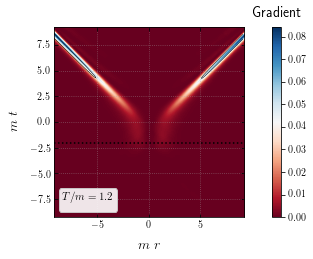

No handles with labels found to put in legend.


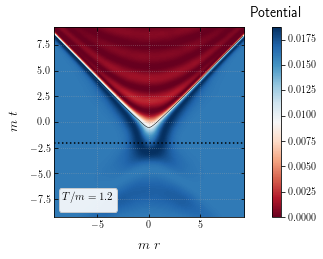

No handles with labels found to put in legend.


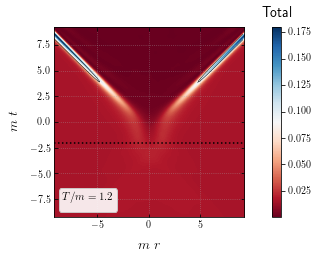

In [11]:
for cp in range(4): # 0 - field, 1 - momentum, 2 - gradient
    tp = 0# 0 for average, 1 for error

    for ii, average_bubble in enumerate(bubbleList):
        tmp = tmpList[ii]
        if tmp!=3: continue

        phi0, temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
        exp_params = np.asarray([nLat, lamb, phi0, temp])

        nT, nN = np.shape(average_bubble[0,0])
        tcen, xcen  = find_nucleation_center2(average_bubble[0,0], phieq, crit_thresh, crit_rad)
        tl, tr      = max(0, tcen-win), min(nT-1, tcen+win)
        xl, xr      = max(0, xcen-win), min(nN-1, xcen+win)

        kinetic, gradient, potential = 0.5*average_bubble[0, 1, tl:tr, xl:xr]**2., 0.5*average_bubble[0, 2, tl:tr, xl:xr]**2., V(average_bubble[0, 0, tl:tr, xl:xr], lamb)
        totEbubble = kinetic + gradient + potential
        picks = [kinetic, gradient, potential, totEbubble]
        bubble2plot = picks[cp]

        bubble2measure = average_bubble[0, 0, tl:tr, xl:xr]
        nT, nN = np.shape(bubble2measure)
        tcen, xcen = find_nucleation_center2(bubble2measure, phieq, crit_thresh, crit_rad)
        ext  = np.asarray([(-xcen), (nN-xcen), (-tcen), (nT-tcen)])*np.sqrt(m2(lamb))*dx

        fig, ax = plt.subplots(1, 1, figsize = (10, 3.5))
        titl = ['Kinetic', 'Gradient', 'Potential', 'Total']
        labss = r'$T/m = {}$'.format(round(temp/np.sqrt(m2(lamb)),1))#labl(lamb, phi0, temp)
        lsl = ('-' if tmp==0 else '--' if tmp==1 else ':')

        im = plt.imshow(bubble2plot, interpolation='antialiased', extent=ext, origin='lower', cmap='RdBu')

        tt = np.arange(-tcen, nT-tcen)*np.sqrt(m2(lamb))*dx
        xx = np.arange(-xcen, nN-xcen)*np.sqrt(m2(lamb))*dx
        ttt1, xxx1 = np.meshgrid(tt, xx)

        lavs = (10 if cp==0 else 1)
        plt.contour(xxx1, ttt1, bubble2plot.T, levels=lavs, aspect='auto', interpolation='none', extent=ext, origin='lower', colors='k',linewidths=0.5)
        cbar = fig.colorbar(im)
        cbar.ax.set_title(titl[cp])
        ax.tick_params(direction='in', which='both', top=True, right=True)
        ax.set(xlabel=r'$m \; r$')

        indmin = int(tcritList[ii])
        ax.axhline((indmin-tl+1-tcen)*np.sqrt(m2(lamb))*dx, ls=':', color='k')
        ax.grid(ls=':', color='darkgray', alpha=0.5)
        ax.set(ylabel=r'$m \; t$')
        plt.legend(title=labss, loc=3, fancybox=True, frameon=True, framealpha=0.9, borderpad=0.3)
        plt.savefig('./plots/average_vacuum_bubble_energies_comparison_'+str(cp)+'.pdf')
        plt.show()


In [12]:
sigmafld0 = np.array([fluct_stdev(lamb, phi0, ti)**2. for ti in tempList[tmpList]])
sigmafld0 = fluct_stdev(lamb, phi0, 0.)**2.

kUV = 2.*np.pi/lenLat*knyq
kIR = 2.*np.pi/lenLat
num = kUV + np.sqrt(kUV**2. + m2(lamb))
denom = kIR + np.sqrt(kIR**2. + m2(lamb))

sigmasqreno = np.log(num/denom)
sigmasqreno = sigmasqreno/np.pi

diffen = sigmasqreno / sigmafld0**2.

diffen = 2*np.pi*phi0**2.
print(diffen)

12.249393256414741


In [13]:
def get_stuffs(nsets):
    partdat = np.zeros((len(tmpList), nsets))
    for ii, average_bubble in enumerate(reversed(bubbleList)):
        tmp = tmpList[ii]
        phi0, temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
        exp_params = np.asarray([nLat, lamb, phi0, temp])

        veldata = np.array(np.load(velocities_file(*exp_params)))
        simvels, all_vels = veldata[:,0].astype(int), veldata[:,1]

        pool = set(all_vels)
        means, vars = np.empty(nsets), np.empty(nsets)
        slen = int(round(len(pool) / nsets,1))
        for ss in range(nsets):
            velssec = random.sample(pool, slen)
            pool -= set(velssec)
            partdat[tmp,ss] = np.var(velssec)
    return partdat

ecrit, esph, alldat = np.zeros((3, len(tmpList)))
for ii, average_bubble in enumerate(reversed(bubbleList)):
    tmp = tmpList[ii]
    phi0, temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
    exp_params = np.asarray([nLat, lamb, phi0, temp])

    veldata = np.array(np.load(velocities_file(*exp_params)))
    simvels, all_vels = veldata[:,0].astype(int), veldata[:,1]
    alldat[tmp] = np.var(all_vels)

    instanton  = instantonList[tmp]
    gradinst   = (np.roll(instanton,-1) - instanton)/dx
    ecrit[tmp] = np.trapz(0.5*gradinst**2. + V(instanton, lamb) - V(phieq,lamb), dx=dx, axis=0)

    esph[tmp] = encritList[tmp]

sigma_avbub = 2.*tempList[tmpList]*(4.*nu)**0.5 / esph
sigma_crit  = 2.*tempList[tmpList]*(4.*nu)**0.5 / ecrit

sigma_avbub = 2.*tempList[tmpList] / (esph * diffen)
sigma_crit  = 2.*tempList[tmpList] / (ecrit * diffen)


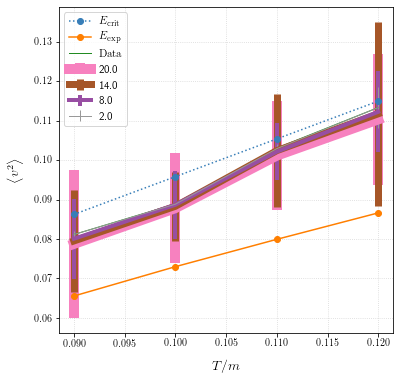

In [14]:
fig, ax = plt.subplots(1,1, figsize = (6,6))
ax.plot(tempList[tmpList], sigma_crit, ls=':', marker='o', label=r'$E_{\rm crit}$')
ax.plot(tempList[tmpList], sigma_avbub, ls='-', marker='o', label=r'$E_{\rm exp}$')
ax.plot(tempList[tmpList], alldat, alpha=1, lw=1, label=r'$\rm Data$')

for nsets in reversed(np.linspace(2, 20, 4)):
    partdat = get_stuffs(int(nsets))
    ax.errorbar(tempList[tmpList], np.mean(partdat, axis=-1), yerr=np.std(partdat, axis=-1), alpha=1, lw=nsets//2, label=nsets)

ax.legend()
ax.grid(ls=':', color='darkgray',alpha=0.5)
ax.set_xlabel(r'$T/m$')
ax.set_ylabel(r'$\left<v^2\right>$')
plt.show()


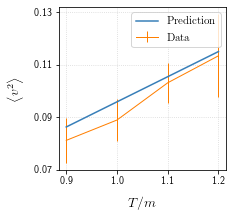

In [15]:
partdat = get_stuffs(10)

fig, ax = plt.subplots(1,1, figsize = (3,3))
ax.plot(tempList[tmpList]/m2(lamb)**0.5, sigma_crit, ls='-', label=r'$\rm Prediction$')
ax.errorbar(tempList[tmpList]/m2(lamb)**0.5, alldat, yerr=np.std(partdat, axis=-1), alpha=1, lw=1, label=r'$\rm Data$')

a = ax.get_xticks().tolist()[1:-1:]
a = [round(al,2) for al in a]
ax.set_xticks(a)
ax.set_xticklabels(a)
a = ax.get_yticks().tolist()[1:-1:2]
a = [round(al,2) for al in a]
ax.set_yticks(a)
ax.set_yticklabels(a)

ax.legend()
ax.grid(ls=':', color='darkgray',alpha=0.5)
ax.set_xlabel(r'$T/m$')
ax.set_ylabel(r'$\left<v^2\right>$')
plt.savefig('./plots/comparison_vels_var.pdf'); plt.show()


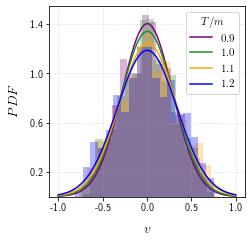

In [16]:
fig, ax = plt.subplots(1,1, figsize = (3.5,3.5))
cols = cycle(['purple', 'forestgreen', 'orange', 'blue'])
for ii, average_bubble in enumerate(reversed(bubbleList)):
    tmp = tmpList[ii]
    phi0, temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
    exp_params = np.asarray([nLat, lamb, phi0, temp])
    labss = r'${}$'.format(round(temp/np.sqrt(m2(lamb)),1))#labl(lamb, phi0, temp)

    veldata = np.array(np.load(velocities_file(*exp_params)))
    simvels, all_vels = veldata[:,0].astype(int), veldata[:,1]

    col = next(cols)
    plt.hist(all_vels, bins=18, alpha=0.3, color=col, density=True)

    mu = 0.
    xlist = np.linspace(-1.,1.,1000)
#    ax.plot(xlist, scp.stats.norm.pdf(xlist, mu, sigma_avbub[tmp]**0.5), ls='-', color=col)

    meanvel, varvel = np.mean(all_vels), np.std(all_vels)
    ax.plot(xlist, scp.stats.norm.pdf(xlist, meanvel, varvel), color=col, label=labss)#r'$\rm Data$')

a = ax.get_xticks().tolist()[1:-1:]
a = [round(al,2) for al in a]
ax.set_xticks(a)
ax.set_xticklabels(a)
a = ax.get_yticks().tolist()[1:-1:2]
a = [round(al,2) for al in a]
ax.set_yticks(a)
ax.set_yticklabels(a)

ax.legend(title=r'$T/m$', ncol=1, loc='best')
ax.grid(ls=':', color='darkgray',alpha=0.5)
ax.set_xlabel(r'$v$'); ax.set_ylabel(r'$PDF$')
plt.savefig('./plots/comparison_vels_PDF.pdf'); plt.show()


No handles with labels found to put in legend.


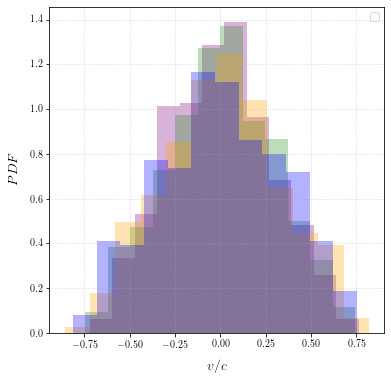

In [17]:
fig, ax = plt.subplots(1,1, figsize = (6,6))
cols = cycle(['purple', 'forestgreen', 'orange', 'blue'])
for ii, average_bubble in enumerate(reversed(bubbleList)):
    tmp = tmpList[ii]
    phi0, temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
    exp_params = np.asarray([nLat, lamb, phi0, temp])

    veldata = np.array(np.load(velocities_file(*exp_params)))
    simvels, all_vels = veldata[:,0].astype(int), veldata[:,1]

    col = next(cols)
    plt.hist(all_vels, bins=12, alpha=0.3, color=col, density=True)

    # fit a straight line
    #all_vels = np.sort(all_vels[(all_vels>0)&(all_vels<1)])
    #jfit_times = lin_fit_times2(all_vels,len(all_vels),0,1)
    #print(jfit_times)
   # ax.plot(all_vels, np.exp(get_line(all_vels, *jfit_times)), alpha=0.8, lw=4, label=r'$\rm Data$')

ax.legend()
ax.grid(ls=':', color='darkgray',alpha=0.5)
ax.set_xlabel(r'$v/c$'); ax.set_ylabel(r'$PDF$')
plt.savefig('./plots/comparison_vels_PDF.pdf'); plt.show()


In [18]:
def lin_fit_times2(times,num,tmin,tmax):
    t = np.sort(times)
    p = survive_prob2(times, num)
    ii = np.where( (t>tmin) & (t<tmax) )
    return np.polyfit(t[ii], np.log(p[ii]), deg=1)

def survive_prob2(t_decay, num_samp):
    frac_remain = float(num_samp-t_decay.size)/float(num_samp)
    print(frac_remain)
    prob = np.linspace(1./num_samp, 1.-frac_remain, t_decay.size, endpoint=True)
    return prob
